In [1]:
library(data.table)
library(dplyr)
library(Matrix)
library(BuenColors)
library(stringr)
library(cowplot)
library(irlba)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
#-----------
# Parameters
#-----------
# n_cells Number of cells from each group to be simulated; either a number (all the same) or a vector
# of length(which_celltypes)

# which_celltypes Number of groups to partition cells into (even groups); must evenly divide into n_cells
# n_frags_per_cell number of fragments in peaks to be simulated per single cell

# rate_noise number between 0 (perfect downsample) and 1 (nonsense) for noise

# seed rando parameter for setting the seed
# shuffle Randomly order the resulting cells and peaks

bulk <- data.matrix(data.frame(fread("./bonemarrow_data/exp100-bulk.counts.txt")))
peaks <- fread("./bonemarrow_data/multiplex_bonemarrow_peaks.bed")
colnames(bulk) <- c("B", "CD4", "CD8", "CLP", "CMP", "Ery", "GMP", "GMP-A", "GMP-B", "GMP-C",
                    "HSC", "LMPP", "MCP", "mDC", "Mega", "MEP", "Mono", "MPP",
                    "NK", "pDC", "GMPunknown")

simulate_scatac <- function(n_cells, which_celltypes, n_frags_per_cell = 1000, 
                            rate_noise = 0, seed = 100, shuffle = FALSE){
  
  # Reproducibility
  set.seed(seed)
  which_celltypes <- sort(which_celltypes)
  stopifnot(rate_noise < 1) 
  stopifnot(n_frags_per_cell > 100)
  n_peaks <- dim(bulk)[1]
  #--
  # Set up cell labels
  #--
  
  if(length(n_cells) > 1){
    stopifnot(length(which_celltypes) == length(n_cells))
    
    # Generate cell labels
    cell_labels <- sapply(1:length(which_celltypes), function(i){
      rep(which_celltypes[i], n_cells[i])
    }) %>% unlist() %>% sort()
    
  } else {
#     n_groups <- length(which_celltypes)
#     cell_labels <- sort(rep(which_celltypes, n_cells*n_groups))
      cell_labels <- sort(rep(which_celltypes, n_cells))
  }
  final_names <- paste0(cell_labels, "_", as.character(1:length(cell_labels)))
  
  
  #-------------------
  # Simulate true data
  #-------------------
  
  # Generate cell-type specific peaks
  lapply(which_celltypes, function(celltype){
    
    # Apply different rates per cell depending on group label for generating cell-type specific peaks
    n_cells_this_celltype <- sum(cell_labels == celltype)
    counts_celltype <- bulk[,celltype]
    
    # Define probabilities
    #                        Prob observting frag                Total number of fragments epxpected; the 0.5s are for two alleles that will be simulated/added later
    prob_per_peaks <- counts_celltype/sum(counts_celltype) * (n_frags_per_cell*0.5 * (1-rate_noise)) + ((rate_noise*n_frags_per_cell)/n_peaks*0.5) 
    
    # Cap probabilities at something sensible
    prob_per_peaks <- ifelse(prob_per_peaks > 0.9, 0.9, prob_per_peaks)
    
    # Represent the two haplotypes as two random draws
    mat1 <- (matrix(rbinom(n_peaks*n_cells_this_celltype, size = 1, prob = prob_per_peaks),
                    ncol = n_cells_this_celltype, byrow = FALSE) )
    mat2 <- (matrix(rbinom(n_peaks*n_cells_this_celltype, size = 1, prob = prob_per_peaks),
                    ncol = n_cells_this_celltype, byrow = FALSE) )
    
    mat <- mat1 + mat2
    Matrix(mat)
  }) %>% do.call(what = "cbind") -> sparse_matrix
  
  colnames(sparse_matrix) <- final_names
  peaknames = paste(peaks$V1,peaks$V2,peaks$V3,sep = "_")
  rownames(sparse_matrix) <- peaknames
  sparse_matrix
}

In [3]:
# Do a basic LSI embedding to assess
compute_LSI <- function(x){
  nfreqs <- t(t(x) / Matrix::colSums(x))
  idf <- as(log(1 + ncol(x) / Matrix::rowSums(x)), "sparseVector")
  tf_idf_counts <- as(Diagonal(x=as.vector(idf)), "sparseMatrix") %*% nfreqs
  SVD_x <-  irlba(tf_idf_counts, 3, 3)
  d_diag = matrix(0, nrow=length(SVD_x$d), ncol=length(SVD_x$d))
  diag(d_diag) = SVD_x$d
  LSI_x_final = t(d_diag %*% t(SVD_x$v))
  LSI_x_final
}

# Function to do LSI and then create the corresponding data frame
makeLSI_df <- function(simulated){
  # Compute LSI and extract cell types from previous simulation
  LSI_dims <- compute_LSI(simulated)
  celltypes <- str_split_fixed(colnames(simulated), "_", 2)[,1]
  
  # Make one data frame for plotting
  LSI_df <- data.frame(
    LSI_2 = LSI_dims[,2],
    LSI_3 = LSI_dims[,3],
    celltype = celltypes,
    cell_id = colnames(simulated)
  )
  LSI_df
}

In [4]:
# Here, we call the function above to simulate data
simulated_cov5000 <- simulate_scatac(200, c("Ery", "CMP", "CD8", "HSC", "CD4", "NK"), rate_noise = 0.2,
                                     n_frags_per_cell = 5000)
simulated_cov2500 <- simulate_scatac(200, c("Ery", "CMP", "CD8", "HSC", "CD4", "NK"), rate_noise = 0.2,
                                     n_frags_per_cell = 2500)
simulated_cov1000 <- simulate_scatac(200, c("Ery", "CMP", "CD8", "HSC", "CD4", "NK"), rate_noise = 0.2,
                                     n_frags_per_cell = 1000)
simulated_cov500 <- simulate_scatac(200, c("Ery", "CMP", "CD8", "HSC", "CD4", "NK"), rate_noise = 0.2,
                                     n_frags_per_cell = 500)
simulated_cov250 <- simulate_scatac(200, c("Ery", "CMP", "CD8", "HSC", "CD4", "NK"), rate_noise = 0.2,
                                     n_frags_per_cell = 250)

In [5]:
head(simulated_cov5000[,1:5])

6 x 5 sparse Matrix of class "dgCMatrix"
                 CD4_1 CD4_2 CD4_3 CD4_4 CD4_5
chr1_9942_10442      .     .     .     .     .
chr1_11036_11536     .     .     .     .     .
chr1_12478_12978     .     .     .     .     .
chr1_13307_13807     .     .     .     .     .
chr1_14399_14899     .     .     .     .     .
chr1_15399_15899     .     .     .     .     .

In [6]:
dim(simulated_cov5000)
median(colSums(simulated_cov5000))

[1] 156311   1200

[1] 4999

In [7]:
median(colSums(simulated_cov250))

[1] 250

In [8]:
# Create two LSI dfs to compare
LSI_df_cov5000 <- makeLSI_df(simulated_cov5000)
LSI_df_cov2500 <- makeLSI_df(simulated_cov2500)
LSI_df_cov1000 <- makeLSI_df(simulated_cov1000)
LSI_df_cov500 <- makeLSI_df(simulated_cov500)
LSI_df_cov250 <- makeLSI_df(simulated_cov250)

In [9]:
head(LSI_df_cov5000)

LSI_2,LSI_3,celltype,cell_id
<dbl>,<dbl>,<fct>,<fct>
-0.002821131,0.001786219,CD4,CD4_1
-0.002919273,0.001682320,CD4,CD4_2
-0.003108915,0.001810387,CD4,CD4_3
-0.003015786,0.001717930,CD4,CD4_4
-0.003154692,0.001950340,CD4,CD4_5
-0.002934614,0.001889895,CD4,CD4_6


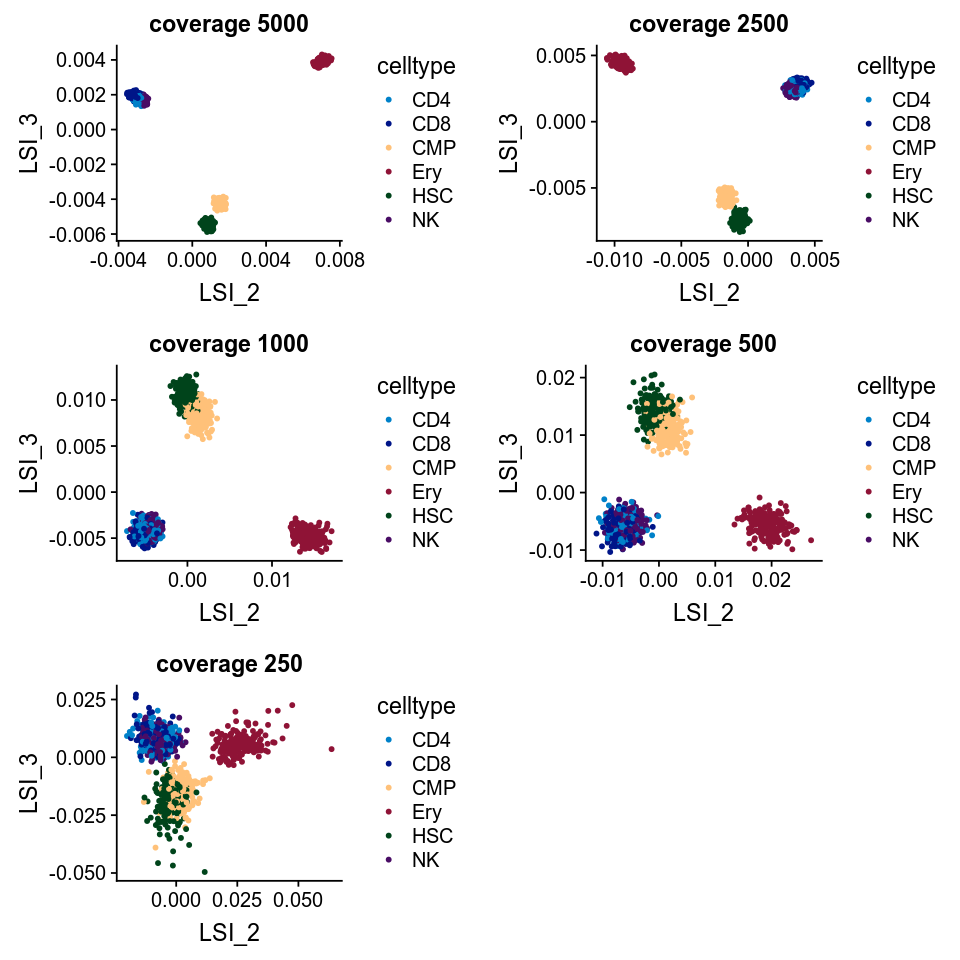

In [10]:
options(repr.plot.width=8, repr.plot.height=8)
p1 <- ggplot(shuf(LSI_df_cov5000), aes(x = LSI_2, y = LSI_3, color = celltype)) +
  geom_point(size = 1) + scale_color_manual(values = jdb_color_maps) +
  ggtitle("coverage 5000")

p2 <- ggplot(shuf(LSI_df_cov2500), aes(x = LSI_2, y = LSI_3, color = celltype)) +
  geom_point(size = 1) + scale_color_manual(values = jdb_color_maps) +
  ggtitle("coverage 2500")

p3 <- ggplot(shuf(LSI_df_cov1000), aes(x = LSI_2, y = LSI_3, color = celltype)) +
  geom_point(size = 1) + scale_color_manual(values = jdb_color_maps) +
  ggtitle("coverage 1000")

p4 <- ggplot(shuf(LSI_df_cov500), aes(x = LSI_2, y = LSI_3, color = celltype)) +
  geom_point(size = 1) + scale_color_manual(values = jdb_color_maps) +
  ggtitle("coverage 500")

p5 <- ggplot(shuf(LSI_df_cov250), aes(x = LSI_2, y = LSI_3, color = celltype)) +
  geom_point(size = 1) + scale_color_manual(values = jdb_color_maps) +
  ggtitle("coverage 250")

# cowplot::ggsave(cowplot::plot_grid(p1, p2, nrow = 1), 
#                 filename = "../output/simulated_comparison.pdf", width = 9, height = 4)
cowplot::plot_grid(p1, p2, p3, p4, p5,ncol = 2)

In [11]:
saveRDS(simulated_cov5000,'../../BoneMarrow_cov5000/input/bonemarrow_cov5000.rds')
saveRDS(simulated_cov2500,'../../BoneMarrow_cov2500/input/bonemarrow_cov2500.rds')
saveRDS(simulated_cov1000,'../../BoneMarrow_cov1000/input/bonemarrow_cov1000.rds')
saveRDS(simulated_cov500,'../../BoneMarrow_cov500/input/bonemarrow_cov500.rds')
saveRDS(simulated_cov250,'../../BoneMarrow_cov250/input/bonemarrow_cov250.rds')

In [12]:
write.table(data.frame(label = LSI_df_cov5000$celltype, row.names = LSI_df_cov5000$cell_id,stringsAsFactors=FALSE),
            '../../BoneMarrow_cov5000/input/metadata.tsv',quote=FALSE, sep='\t', col.names = NA)
write.table(data.frame(label = LSI_df_cov2500$celltype, row.names = LSI_df_cov2500$cell_id,stringsAsFactors=FALSE),
            '../../BoneMarrow_cov2500/input/metadata.tsv',quote=FALSE, sep='\t', col.names = NA)
write.table(data.frame(label = LSI_df_cov1000$celltype, row.names = LSI_df_cov1000$cell_id,stringsAsFactors=FALSE),
            '../../BoneMarrow_cov1000/input/metadata.tsv',quote=FALSE, sep='\t', col.names = NA)
write.table(data.frame(label = LSI_df_cov500$celltype, row.names = LSI_df_cov500$cell_id,stringsAsFactors=FALSE),
            '../../BoneMarrow_cov500/input/metadata.tsv',quote=FALSE, sep='\t', col.names = NA)
write.table(data.frame(label = LSI_df_cov250$celltype, row.names = LSI_df_cov250$cell_id,stringsAsFactors=FALSE),
            '../../BoneMarrow_cov250/input/metadata.tsv',quote=FALSE, sep='\t', col.names = NA)